# Denoising using Gaussian filter
$$G(x, y) = \frac{1}{2 \pi \sigma^2} \cdot e^{-\frac{x^2 + y^2}{2 \sigma^2}}$$

In [1]:
import cv2
from skimage import io, img_as_float
from skimage.filters import gaussian
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# image with gaussian noise
img_with_gnoise = img_as_float(io.imread("../inpdata/images/Osteosarcoma_01_25Sigma_noise.tif", as_gray=True)) 

# image with salt pepper noise
img_with_spnoise = img_as_float(io.imread("../inpdata/images/Osteosarcoma_01_8bit_salt_pepper_cropped.tif", as_gray=True))

In [3]:
# let's add gaussian blur
bimg_cv2 = cv2.GaussianBlur(img_with_gnoise, (3, 3), 0, borderType=cv2.BORDER_CONSTANT)
bimg_sk = gaussian(img_with_gnoise, sigma = 1, mode = "constant", cval = 0.0)


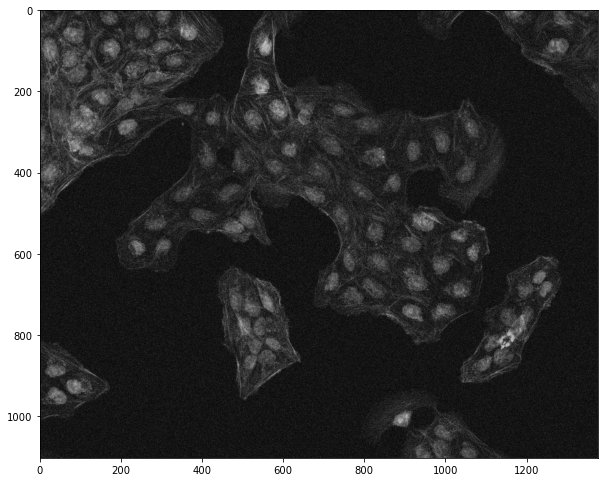

In [4]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_with_gnoise, cmap = "gray")

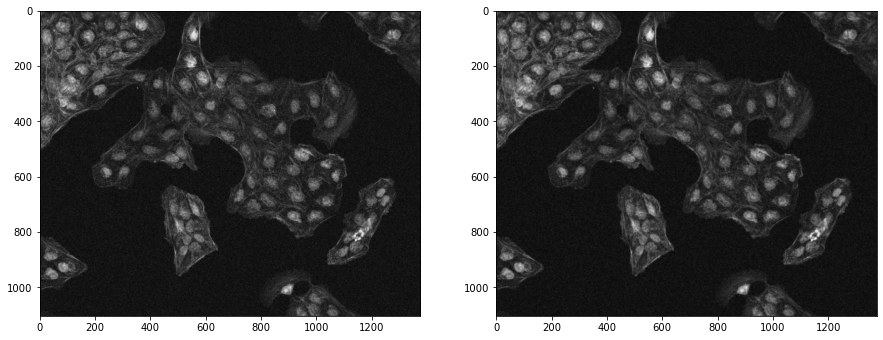

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 8))
axs.flatten()[0].imshow(bimg_cv2, cmap = "gray")
axs.flatten()[1].imshow(bimg_sk, cmap = "gray")

Gaussian filter doesn't work well with the "salt-pepper" noise type. 

(-0.5, 709.5, 641.5, -0.5)

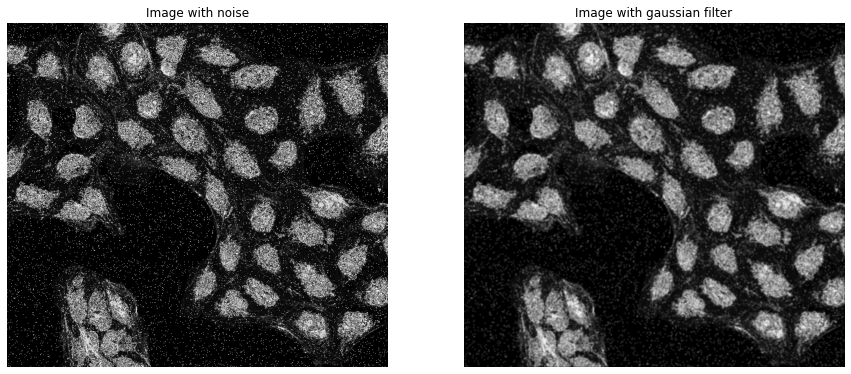

In [6]:
bimg_cv2 = cv2.GaussianBlur(img_with_spnoise, (5, 5), 0, borderType=cv2.BORDER_CONSTANT)

fig, axs = plt.subplots(ncols=2, figsize=(15, 8))
axs.flatten()[0].imshow(img_with_spnoise, cmap = "gray")
axs.flatten()[0].title.set_text("Image with noise")
axs.flatten()[0].axis("off")

axs.flatten()[1].imshow(bimg_cv2, cmap = "gray")
axs.flatten()[1].title.set_text("Image with gaussian filter")
axs.flatten()[1].axis("off")

For such type of noises better use median filter:

# Denoising using Median filter

In [7]:
from skimage.filters import median
from skimage.morphology import disk

In [8]:
# img with noise:
nimg = img_as_float(io.imread("../inpdata/images/Osteosarcoma_01_8bit_salt_pepper_cropped.tif"))

(-0.5, 709.5, 641.5, -0.5)

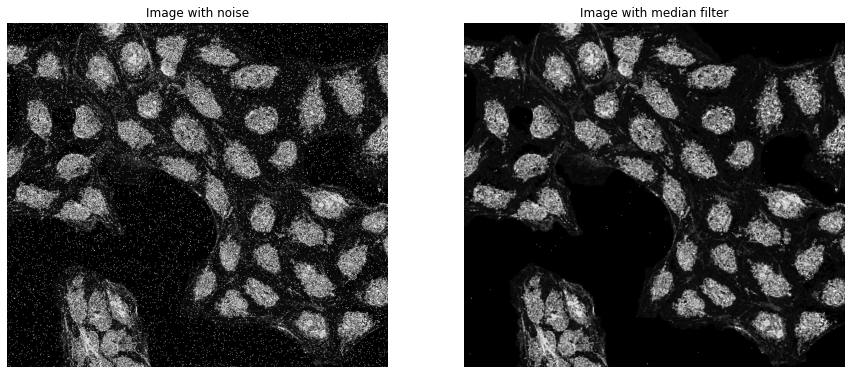

In [9]:
unimg = median(nimg, disk(1), mode="constant", cval=0.0)

fig, axs = plt.subplots(ncols=2, figsize=(15, 8))
axs.flatten()[0].imshow(nimg, cmap = "gray")
axs.flatten()[0].title.set_text("Image with noise")
axs.flatten()[0].axis("off")

axs.flatten()[1].imshow(unimg, cmap = "gray")
axs.flatten()[1].title.set_text("Image with median filter")
axs.flatten()[1].axis("off")

# Bilaterial filter for denoising

- Edge preserving denoising filter
- Replaces each pixel value with a weighted average of nearby pixel values. (But, takes into account the variation of intensities to preserve edges)

$$BF\left[I\right]_p = \frac{1}{W_p} \sum\limits_{q \ in S} G_{\sigma_s} \left(\lVert p - q \rVert\right) G_{\sigma_r} \left( I_p - I_q\right) I_q$$
where
$$W_p = \sum\limits_{q \ in S} G_{\sigma_s} \left(\lVert p - q \rVert\right) G_{\sigma_r} \left( I_p - I_q\right)$$
$\sigma_s$ and $\sigma_r$ -- parameters that control the amount of filtering. $\sigma_s$ (spatial) controls influence of distant pixels, $\sigma_r$ (range)

In [10]:
img = np.array(img_with_gnoise, dtype=np.float32)
unimg = cv2.bilateralFilter(img, 5, 20, 100, borderType=cv2.BORDER_CONSTANT)

(-0.5, 1375.5, 1103.5, -0.5)

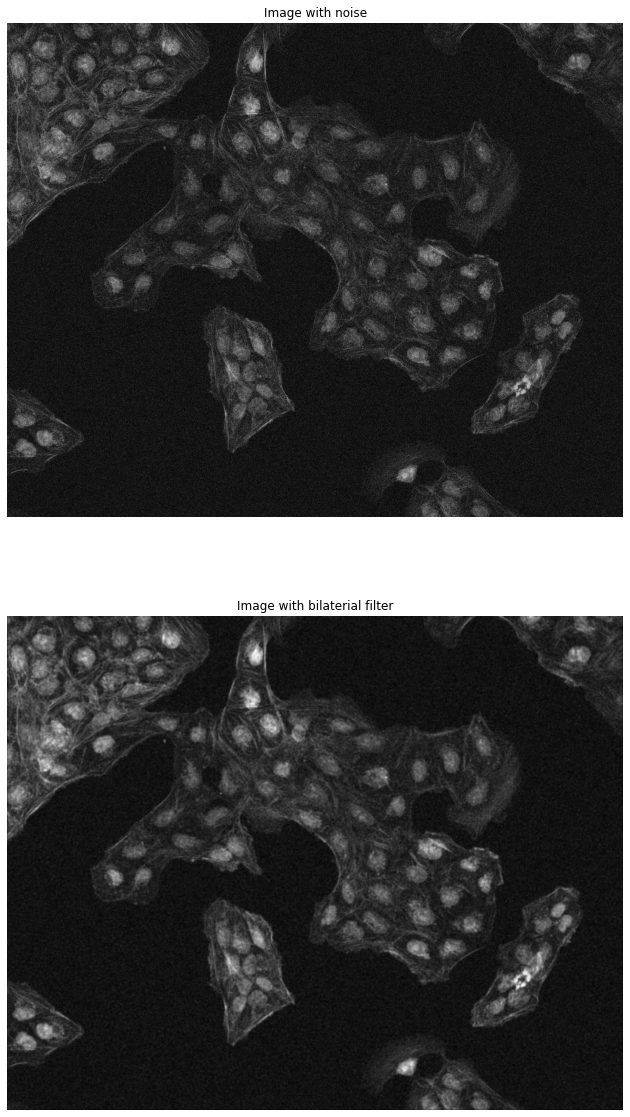

In [11]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
axs.flatten()[0].imshow(img, cmap = "gray")
axs.flatten()[0].title.set_text("Image with noise")
axs.flatten()[0].axis("off")

axs.flatten()[1].imshow(unimg, cmap = "gray")
axs.flatten()[1].title.set_text("Image with bilaterial filter")
axs.flatten()[1].axis("off")

# Non-local means filter
Suppose $\Omega$ is the area of the image, and $p$ and $q$ are two points within the image. Then, the algorithm is:
$$u(p) = \frac{1}{C_p} \int_{\Omega} v(q) f(p, q)dq,$$
where $u(p)$ is the filtered value of the image at point $p$, $v(q)$ is the unfiltered value of the image at point $q$, $f(p, q)$ is the weighting function, and the integral is evaluated $\forall q \in \Omega$. $C_p$ is a normalizing factor, given by:
$$C_p = \int_{\Omega} f(p, q) dq$$

In [12]:
from skimage.restoration import denoise_nl_means, estimate_sigma

In [13]:
img = img_as_float(io.imread("../inpdata/images/Osteosarcoma_01_25Sigma_noise.tif", as_gray=False))
img.shape

(1104, 1376, 3)

In [14]:
sigma_hat = np.mean([estimate_sigma(ch) for ch in cv2.split(img)])
sigma_hat

0.06478836522694023

In [15]:
unimg = denoise_nl_means(img, h=1.5 * sigma_hat,
                        fast_mode=True,
                        patch_size=5,
                        patch_distance=3,
                        multichannel=True)

/tmp/ipykernel_13587/3099803296.py:1: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  unimg = denoise_nl_means(img, h=1.5 * sigma_hat,


(-0.5, 1375.5, 1103.5, -0.5)

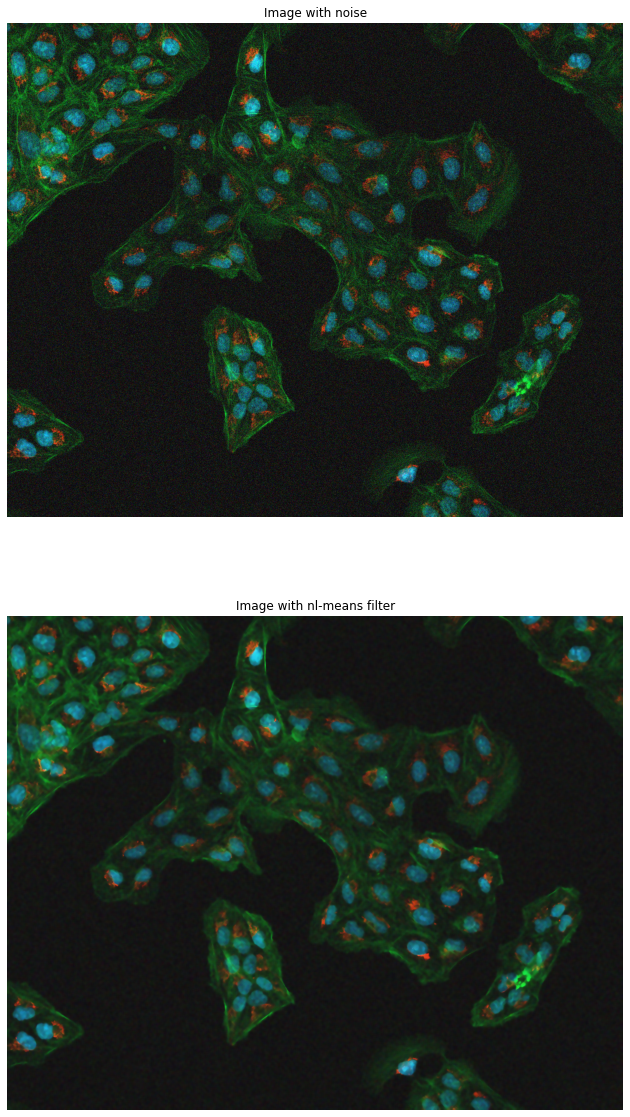

In [16]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
axs.flatten()[0].imshow(img, cmap = "gray")
axs.flatten()[0].title.set_text("Image with noise")
axs.flatten()[0].axis("off")

axs.flatten()[1].imshow(unimg, cmap = "gray")
axs.flatten()[1].title.set_text("Image with nl-means filter")
axs.flatten()[1].axis("off")

# Total variation filter

In [17]:
from skimage.restoration import denoise_tv_chambolle

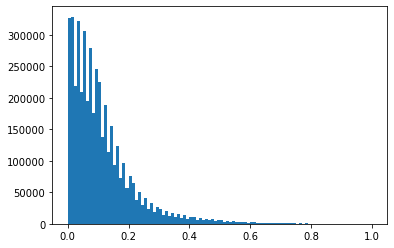

In [18]:
img = img_as_float(io.imread("../inpdata/images/Osteosarcoma_01_25Sigma_noise.tif"))
plt.hist(img.flat, bins = 100, range=(0, 1))
plt.show()

In [19]:
unimg = denoise_tv_chambolle(img, weight=0.1, eps=0.1, max_num_iter=200, multichannel=True)

/tmp/ipykernel_13587/3803829595.py:1: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  unimg = denoise_tv_chambolle(img, weight=0.1, eps=0.1, max_num_iter=200, multichannel=True)


(-0.5, 1375.5, 1103.5, -0.5)

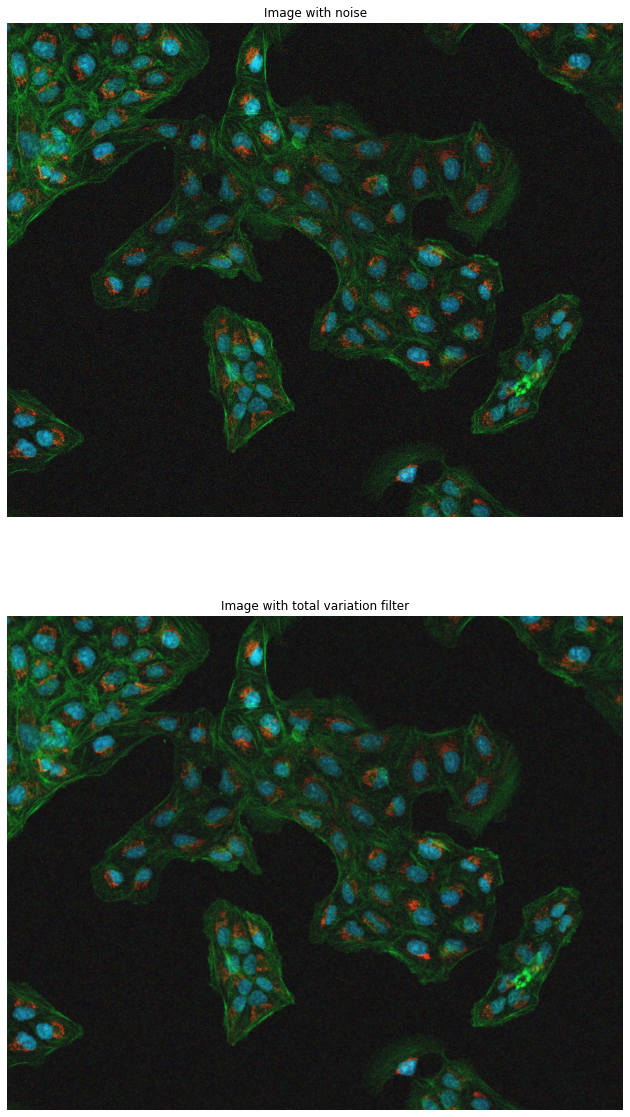

In [22]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
axs.flatten()[0].imshow(img, cmap = "gray")
axs.flatten()[0].title.set_text("Image with noise")
axs.flatten()[0].axis("off")

axs.flatten()[1].imshow(unimg, cmap = "gray")
axs.flatten()[1].title.set_text("Image with total variation filter")
axs.flatten()[1].axis("off")

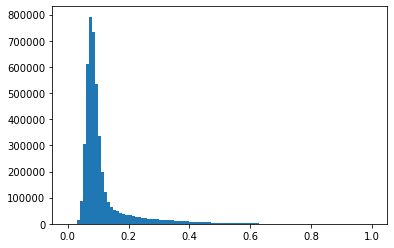

In [21]:
plt.hist(unimg.flat, bins = 100, range=(0, 1))
plt.show()

# Denoising using Block Matching & 3D filtering (BM3D)
is a 3-D block-matching algorithm used primarily for noise reduction in images. It is one of the expansions of the non-local means methodology. There are two cascades in BM3D: a hard-thresholding and a Wiener filter stage, both involving the following parts: grouping, collaborative filtering, and aggregation. This algorithm depends on an augmented representation in the transformation site.

In [28]:
import bm3d

In [29]:
img = img_as_float(io.imread("../inpdata/images/Osteosarcoma_01_25Sigma_noise.tif", as_gray=True))

In [37]:
unimg = bm3d.bm3d(img, sigma_psd=0.05, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

(-0.5, 1375.5, 1103.5, -0.5)

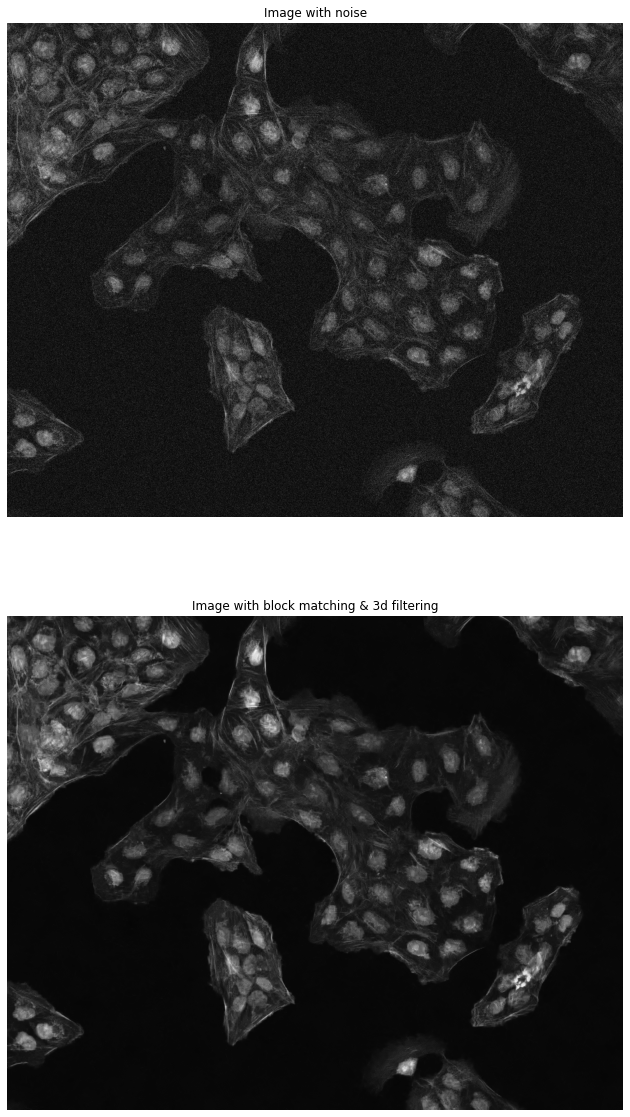

In [38]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
axs.flatten()[0].imshow(img, cmap = "gray")
axs.flatten()[0].title.set_text("Image with noise")
axs.flatten()[0].axis("off")

axs.flatten()[1].imshow(unimg, cmap = "gray")
axs.flatten()[1].title.set_text("Image with block matching & 3d filtering")
axs.flatten()[1].axis("off")